In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root

x = sp.symbols('x')

M_p = 1
b = 2.3e-5

# Definimos el potencial en función de las variables del problema, con x=phi. Lo hago de forma simbólica para luego calcular las derivadas

def potencial(x,kappa,lambda_0,xi):

    return (lambda_0+b*(sp.log((sp.sqrt(xi)/kappa/M_p)*((M_p/sp.sqrt(xi))*sp.sqrt(1-sp.exp(-(sp.sqrt(2/3)/M_p)*x)))))**2)*(((M_p/sp.sqrt(xi))*sp.sqrt(1-sp.exp(-(sp.sqrt(2/3)/M_p)*x)))**4)/4

# Esta función y las siguientes son para calcular phi=phi(N) en función de los parámetros del problema y phi(N=0)
# Lo hago de esta forma y no con la expresión simbólica anterior porque no consigo que funcione bien con odeint

def evol_phi(phi,N,kappa,lambda_0,xi):
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V=potencial(phi[0],kappa,lambda_0,xi)
    Vd=derivada_1.evalf(subs={x: phi[0]})
    
    return sp.sqrt((M_p*Vd/V)**2)

def all_parameters(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
        
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,1000)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    #plt.plot(N,phi_N)
    #plt.title("Campo phi en función de N")
    #plt.show()
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    P_r=sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)
    n_s=1-eta_60-2*eps_60
    r=16*eps_60
    
    print("El valor de n_s es ",n_s)
    print("El valor de r es ", r)
    print("La normalización de P_r es", P_r.evalf())
    print("El valor de eps(0) es ", eps_0)
    
    return [eps_0,n_s,r,P_r]

def fit_phi_0_try(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V_0=potencial(phi_0[0],kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0[0]}) 
    #print("Nueva iteración para phi_0: ",1-((M_p*Vd_0/V_0)**2)/2, phi_0[0])
    
    return 1-((M_p*Vd_0/V_0)**2)/2

def correct_phi_0_try(kappa,xi,lambda_0):
    
    x_0=0.4 #parámetro inicial de iteración
    
    phi_0=fsolve(fit_phi_0_try,x_0,args=(kappa,xi,lambda_0))
    
    return phi_0[0]

def fit(x_fit,kappa):
    
    xi=x_fit[0]
    lambda_0=x_fit[1]
    
    phi_0=correct_phi_0_try(kappa,xi,lambda_0)
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    #Expresión de las derivadas del potencial pero sin evaluar en phi todavía
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,500)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    #plt.plot(phi_N)
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    #Obtengo los parámetros del sistema (potencial, eps y eta) para phi(N=0) (_0) y phi(N=60) (_60)
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    #Para ir viendo como va la iteración
    #print('Epsilon: ',eps_0,', n_s: ',1-eta_60-2*eps_60,', P_r:',sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10).evalf())
    #print("Phi_0: ",phi_0,", xi: ",xi,", lambda_0: ",lambda_0)
    
    #Tiene esta estructura porque fsolve resuelve numéricamente la ecuación f(x)=0
    #En orden: n_s=0.986 (en N=60), fijación del power spectrum (en N=60)
    return [0.968-(1-eta_60-2*eps_60),3.094-sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)]

def power_spectrum_60(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))

    P_r=[]
    
    for i in range(len(N)):
        value=phi_N[len(N)-i-1]
        V=potencial(value[0],kappa,lambda_0,xi)
        Vd=derivada_1.evalf(subs={x: value[0]})
        eps=((M_p*Vd/V)**2)/2
        P_r.append((V/24/sp.pi**2/eps/M_p**4).evalf())
        
    N_plot=np.linspace(60,0,1000)
    
    plt.plot(N_plot,P_r)
    plt.title("Power Spectrum en función de N")
    plt.yscale("log")
    plt.show()
        
    return P_r

def plot_pot(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    plt.plot(N,phi_N)
    plt.title("Campo en función de N")
    plt.show()

    Pot_plot=[]
    
    for i in range(len(N)):
        value=phi_N[i]
        V=potencial(value[0],kappa,lambda_0,xi)

        Pot_plot.append(V.evalf())
        
    plt.plot(phi_N,Pot_plot)
    plt.title("Potencial en función del campo")
    plt.show()
        
    return Pot_plot

In [2]:
def potencial_analy(x):
    
    return 10**-10*(1-sp.exp(-sp.sqrt(2/3)*x))**2

# derivada_1 = sp.diff(potencial_analy(x),x)
# derivada_2 = sp.diff(derivada_1,x)

def evol_phi_analy(phi,N):
    
    derivada_1 = sp.diff(potencial_analy(x),x)
    
    V=potencial_analy(phi[0])
    Vd=derivada_1.evalf(subs={x: phi[0]})
    
    return Vd/V

def all_parameters_analy(phi_0):
    
    derivada_1 = sp.diff(potencial_analy(x),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,1000)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi_analy,phi_0,N)
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    V_0=potencial_analy(phi_0)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial_analy(phi_60)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    P_r=sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)
    n_s=1-eta_60-2*eps_60
    r=16*eps_60
    
    print("El valor de n_s es ",n_s)
    print("El valor de r es ", r)
    print("La normalización de P_r es", P_r.evalf())
    print("El valor de eps(0) es ", eps_0)
    
    return [eps_0,n_s,r,P_r]

def power_spectrum_analy(phi_0):
    
    derivada_1 = sp.diff(potencial_analy(x),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi_analy,phi_0,N)

    P_r=[]
    
    for i in range(len(N)):
        V=potencial_analy(phi_N[i][0])
        Vd=derivada_1.evalf(subs={x: phi_N[i][0]})
        eps=((Vd/V)**2)/2
        P_r.append((V/24/sp.pi**2/eps).evalf())
        
    plt.plot(N,P_r)
    plt.title("Power spectrum en función de N")
    plt.yscale("log")
    plt.show()
        
    return P_r

def fit_phi_0_try_analy(phi_0):
    
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial_analy(x),x)
    
    V_0=potencial_analy(phi_0[0])
    Vd_0=derivada_1.evalf(subs={x: phi_0[0]}) 
    
    return 1-((M_p*Vd_0/V_0)**2)/2

def correct_phi_0_try_analy(x_0):
    
    #x_0=0.94 #parámetro inicial de iteración
    
    phi_0=fsolve(fit_phi_0_try_analy,x_0)
    
    return phi_0[0]

def plot_pot_analy(phi_0):
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial_analy(x),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi_analy,phi_0,N)
    plt.plot(N,phi_N)
    plt.title("Campo en función de N")
    plt.show()

    Pot_plot=[]
    
    for i in range(len(N)):
        value=phi_N[i]
        V=potencial_analy(value[0])

        Pot_plot.append(V.evalf())
        
    plt.plot(phi_N,Pot_plot)
    plt.title("Potencial en función del campo")
    plt.show()
        
    return Pot_plot

In [3]:
# Experimental data from Planck

PLANCK_FIG26_1SIG = np.array([
  [0.00009888171612066994, 3.459459459459459],
  [0.00015680510418533447, 3.4167852062588904],
  [0.00025431525115423724, 3.382645803698435],
  [0.00043631951696497035, 3.3456614509246085],
  [0.0008098878961161774, 3.3115220483641536],
  [0.0016634173269935632, 3.2773826458036983],
  [0.0033782635603094805, 3.2489331436699853],
  [0.0076776071319739495, 3.2261735419630155],
  [0.02444997324816294, 3.189189189189189],
  [0.05252798246288527, 3.166429587482219],
  [0.10198751465593191, 3.143669985775249],
  [0.19361334443605654, 3.12375533428165],
  [0.3474589803990716, 3.1066856330014225],
  [0.7056605658340688, 3.1009957325746798],
  [1, 3.1066856330014225],
  [0.9777593782968718, 2.930298719772404],
  [0.6028645961505653, 2.9672830725462305],
  [0.37171284608372546, 2.9928876244665714],
  [0.25936980404319726, 3.0099573257467993],
  [0.18930726328577654, 3.0184921763869133],
  [0.11412664682914853, 3.038406827880512],
  [0.05683014374985219, 3.0640113798008533],
  [0.03202539577230474, 3.0839260312944523],
  [0.01996945904454089, 3.0981507823613086],
  [0.012175031274276044, 3.118065433854907],
  [0.006708382643365784, 3.1322901849217635],
  [0.003999020237661566, 3.1408250355618774],
  [0.002579154813950523, 3.1379800853485063],
  [0.001799654991048489, 3.1379800853485063],
  [0.0012140849742973486, 3.135135135135135],
  [0.0008376776400682933, 3.1379800853485063],
  [0.0005779692884153325, 3.143669985775249],
  [0.00036446897185184646, 3.143669985775249],
  [0.00023506305230327343, 3.1322901849217635],
  [0.00016964779901568712, 3.126600284495021],
  [0.00012382150910969755, 3.12375533428165],
  [0.00009888171612066994, 3.1009957325746798],
  [0.00010113093089724078, 3.049786628733997],
  [0.00012243683313418034, 3.0327169274537695],
  [0.0001465737388299315, 3.046941678520626],
  [0.000179460244029732, 3.0412517780938835],
  [0.00023772145298976767, 3.0583214793741105],
  [0.0003078934772259479, 3.0753911806543384],
  [0.0004773936949463693, 3.0782361308677095],
  [0.0006183135888417604, 3.0867709815078235],
  [0.0007076472932238888, 3.072546230440967],
  [0.0006614740641230159, 3.044096728307254],
  [0.0006045619102184272, 3.0241820768136556],
  [0.00047205507821484495, 2.975817923186344],
  [0.0004171273057061324, 2.9502133712660026],
  [0.0003113755396904842, 2.9046941678520626],
  [0.00022221038240955961, 2.8364153627311524],
  [0.00016964779901568712, 2.7624466571834994],
  [0.0001433138477530019, 2.725462304409673],
  [0.00012807020581256777, 2.677098150782361],
  [0.00011316810761542673, 2.642958748221906],
  [0.00010113093089724078, 2.6315789473684212],
  [0.000096682525279074, 2.6315789473684212]
])

PLANCK_FIG26_2SIG = np.array([
  [0.00009777593782968737, 3.533428165007112],
  [0.00010698035366845273, 3.533428165007112],
  [0.00012382150910969755, 3.519203413940256],
  [0.00014990778107927094, 3.4935988620199145],
  [0.00019198720375727523, 3.4708392603129443],
  [0.00024587840698573547, 3.4509246088193457],
  [0.00033687790490147105, 3.425320056899004],
  [0.00044624426689210753, 3.399715504978663],
  [0.0005651148921156609, 3.382645803698435],
  [0.0007402064572069475, 3.3655761024182076],
  [0.0009269001811442876, 3.3541963015647225],
  [0.0011477017922333738, 3.3456614509246085],
  [0.0014864871940875966, 3.3314366998577523],
  [0.0020366354969761457, 3.3229018492176383],
  [0.002410867720575777, 3.317211948790896],
  [0.0031935484129089436, 3.3001422475106685],
  [0.004183016922078184, 3.2887624466571834],
  [0.00560368544094395, 3.2773826458036983],
  [0.0074229044561986875, 3.2716927453769555],
  [0.010056387566976558, 3.266002844950213],
  [0.014575187944352343, 3.254623044096728],
  [0.018251319228974466, 3.2460881934566146],
  [0.023638851566381916, 3.240398293029872],
  [0.031313131060039946, 3.2318634423897583],
  [0.04194793850949571, 3.2204836415362728],
  [0.05556620602137732, 3.2147937411095304],
  [0.09321267457487704, 3.1977240398293025],
  [0.12487028313698095, 3.19203413940256],
  [0.1871902706780506, 3.177809388335704],
  [0.25076527636034834, 3.16927453769559],
  [0.3474589803990716, 3.166429587482219],
  [0.4067050914552316, 3.1749644381223328],
  [0.4654656832753585, 3.189189189189189],
  [0.5208680476769061, 3.2119487908961593],
  [0.5894565127293714, 3.243243243243243],
  [0.6449466771037621, 3.2716927453769555],
  [0.7136410992027281, 3.308677098150782],
  [0.7634557718505098, 3.351351351351351],
  [0.7896522868499732, 3.385490753911806],
  [0.8167476848278885, 3.4167852062588904],
  [0.8543266059341125, 3.4281650071123755],
  [0.9037409390018165, 3.433854907539118],
  [0.9560134018474852, 3.4224751066856327],
  [0.9560134018474852, 3.4054054054054053],
  [0.9242978989125282, 3.385490753911806],
  [0.9037409390018165, 3.3570412517780936],
  [0.9347510694338725, 3.334281650071124],
  [0.9888171612066974, 3.328591749644381],
  [1, 2.0398293029871977],
  [0.9242978989125282, 2.0625889046941674],
  [0.9139616245120011, 2.0825035561877665],
  [0.8936345497700531, 2.1052631578947367],
  [0.9037409390018165, 2.1593172119487907],
  [0.8936345497700531, 2.20199146514936],
  [0.873759561807772, 2.2674253200568986],
  [0.8353258510806161, 2.3328591749644376],
  [0.8167476848278885, 2.355618776671408],
  [0.8259845367481016, 2.4011379800853483],
  [0.7896522868499732, 2.4438122332859176],
  [0.7808217326233656, 2.4864864864864864],
  [0.7549181690280876, 2.512091038406828],
  [0.6977692774835542, 2.560455192034139],
  [0.6822504549469788, 2.591749644381223],
  [0.6746209580926479, 2.6230440967283073],
  [0.6449466771037621, 2.65149359886202],
  [0.6235507341273913, 2.6941678520625887],
  [0.6165776667881991, 2.716927453769559],
  [0.5699014419287214, 2.770981507823613],
  [0.544833416216064, 2.8165007112375533],
  [0.515043264267153, 2.859174964438122],
  [0.49795683417325703, 2.8762446657183496],
  [0.46026045557547474, 2.9046941678520626],
  [0.4206603936763955, 2.92176386913229],
  [0.3675560412485722, 2.9388335704125175],
  [0.32478765351243577, 2.9502133712660026],
  [0.28378631781360036, 2.9587482219061165],
  [0.2240925148382426, 2.9672830725462305],
  [0.17895640746367472, 2.975817923186344],
  [0.1397330521398395, 2.984352773826458],
  [0.10668000517444859, 2.995732574679943],
  [0.07963406789959582, 3.007112375533428],
  [0.053122037646255095, 3.0213371266002844],
  [0.03665241237079633, 3.0355618776671403],
  [0.02736014767384981, 3.044096728307254],
  [0.01649446437801531, 3.0640113798008533],
  [0.011771127689487078, 3.0753911806543384],
  [0.008786864793890563, 3.0839260312944523],
  [0.006633363881701235, 3.095305832147937],
  [0.005541020330009503, 3.095305832147937],
  [0.004787377563484056, 3.0924608819345663],
  [0.004183016922078184, 3.0867709815078235],
  [0.0036140783046715343, 3.0782361308677095],
  [0.0033031288784511744, 3.061166429587482],
  [0.002951790088127176, 3.0327169274537695],
  [0.002759188941621185, 3.004267425320057],
  [0.0025217928074196473, 2.9672830725462305],
  [0.002383907375504601, 2.9473684210526314],
  [0.0022535611800718128, 2.9388335704125175],
  [0.002013860130532744, 2.9359886201991463],
  [0.0018824579107057245, 2.9445234708392602],
  [0.0017012542798525926, 2.9530583214793737],
  [0.0015374931403548445, 2.9530583214793737],
  [0.0013894954943731402, 2.941678520625889],
  [0.0012417011805216586, 2.9274537695590324],
  [0.0010608183551394504, 2.9075391180654337],
  [0.0008961505019466069, 2.881934566145092],
  [0.0007402064572069475, 2.8335704125177807],
  [0.000632378070276126, 2.782361308677098],
  [0.0005525463855813123, 2.7425320056899003],
  [0.000499358789347316, 2.7027027027027026],
  [0.0004078501350978772, 2.6315789473684212],
  [0.00036446897185184646, 2.586059743954481],
  [0.00032205979187210893, 2.534850640113798],
  [0.00026601640799467444, 2.460881934566145],
  [0.00023506305230327343, 2.4096728307254622],
  [0.00017546893663151564, 2.304409672830725],
  [0.00013700995912219988, 2.1991465149359883],
  [0.00011837502214585133, 2.128022759601707],
  [0.00010941378425313439, 2.0796586059743953],
  [0.00009888171612066994, 2.04551920341394]  
])

El valor de n_s es  0.967827141744785
El valor de r es  0.00296389031169106
La normalización de P_r es 3.10289163521284
El valor de eps(0) es  1.00000000000000


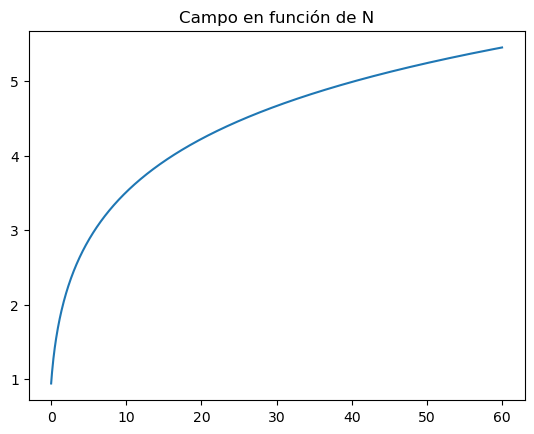

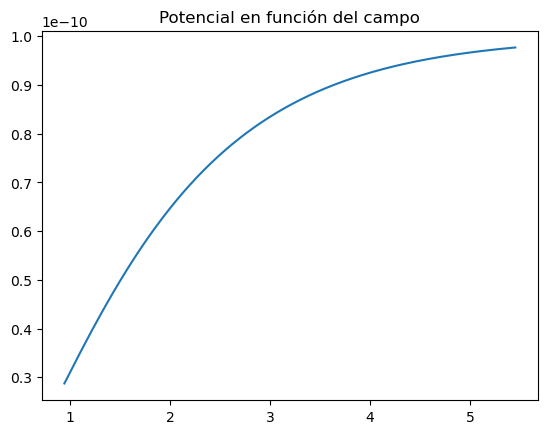

Phi_0:  0.9401775470003005


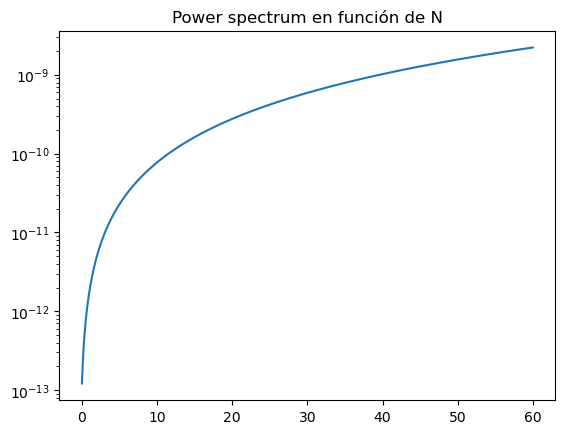

In [4]:
x_0=0.94

phi_0=correct_phi_0_try_analy(x_0)

para=all_parameters_analy(phi_0)
Pot_plot_1=plot_pot_analy(phi_0)
print("Phi_0: ",phi_0)
P_r_ref=power_spectrum_analy(phi_0)

El valor de n_s es  0.968000025490503
El valor de r es  0.00673230255239859
La normalización de P_r es 3.09399983659339
El valor de eps(0) es  1.00000000000000


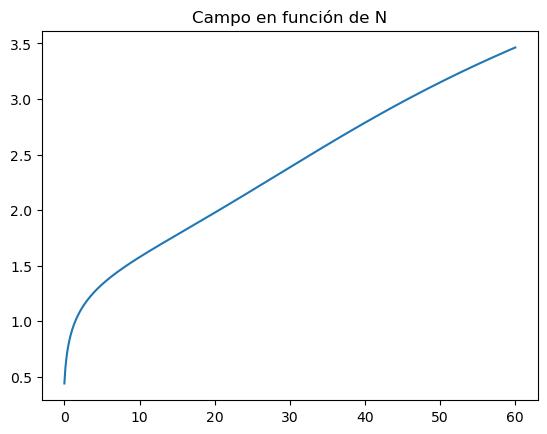

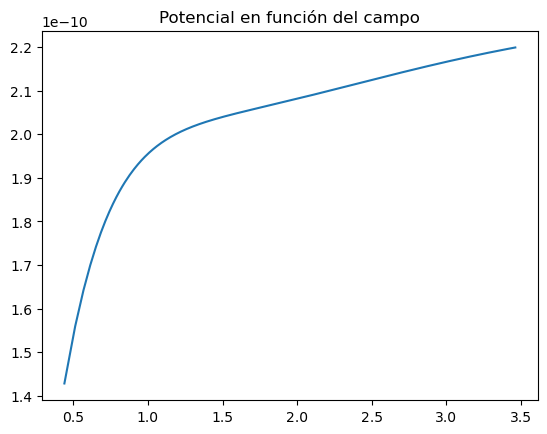

Phi_0:  0.4393392911624097 , Kappa:  1.1 , xi:  45.048100360258715
Lambda_0:  1.6526700129990668e-06 , b/16/kappa:  1.3068181818181816e-06


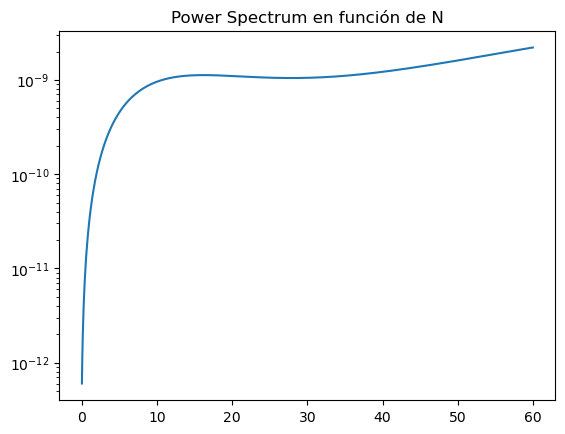

In [5]:
kappa=1.1
lambda_0_0=b/16/0.9
x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

xi=solutions.x[0]
lambda_0=solutions.x[1]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
Pot_plot_1=plot_pot(phi_0,kappa,xi,lambda_0)
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_1_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

El valor de n_s es  0.968000004758852
El valor de r es  0.0147724692065286
La normalización de P_r es 3.09400001500728
El valor de eps(0) es  0.999999999999999


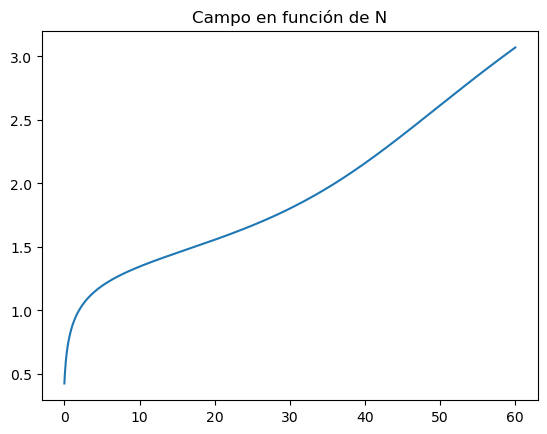

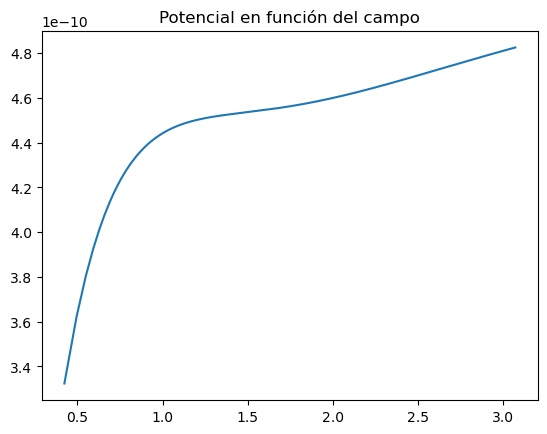

Phi_0:  0.4239877912209537 , Kappa:  1.07 , xi:  28.05676173764572
Lambda_0:  1.5219129713499639e-06 , b/16/kappa:  1.3434579439252335e-06


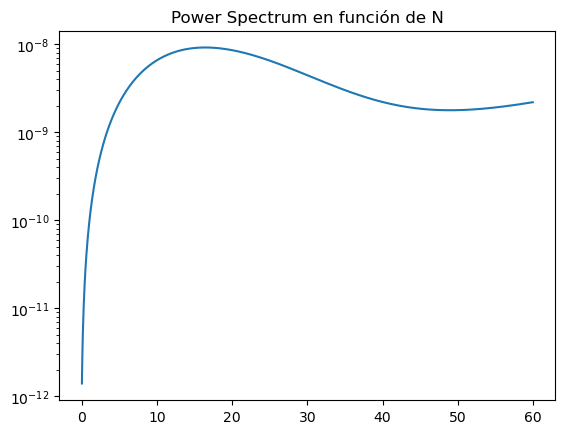

In [6]:
kappa=1.07
lambda_0_0=b/16/0.95
x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

xi=solutions.x[0]
lambda_0=solutions.x[1]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
Pot_plot_1=plot_pot(phi_0,kappa,xi,lambda_0)
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_2_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

El valor de n_s es  0.967999999984326
El valor de r es  0.0269561868627468
La normalización de P_r es 3.09400000699529
El valor de eps(0) es  1.00000000000001


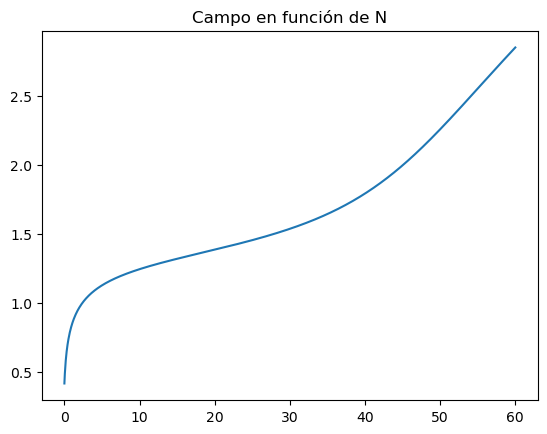

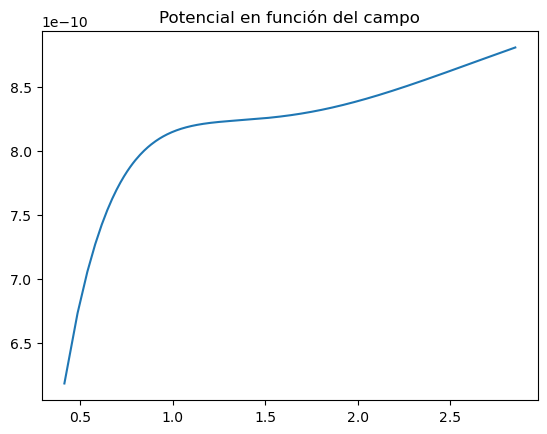

Phi_0:  0.41493057399493993 , Kappa:  1.05 , xi:  19.91509218960142
Lambda_0:  1.484799754091532e-06 , b/16/kappa:  1.369047619047619e-06


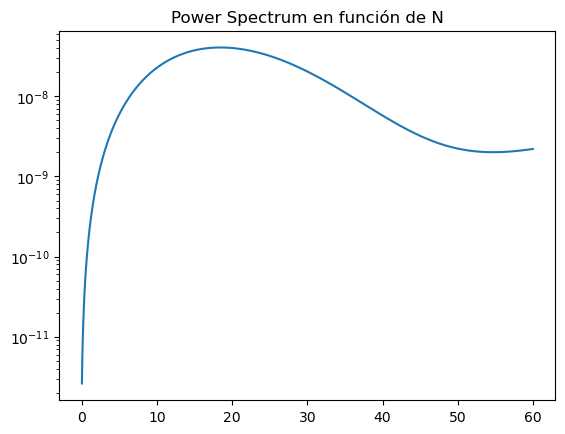

In [7]:
kappa=1.05
lambda_0_0=b/16/0.97
# x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]
x_0=[10,lambda_0_0]

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

xi=solutions.x[0]
lambda_0=solutions.x[1]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
Pot_plot_1=plot_pot(phi_0,kappa,xi,lambda_0)
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_3_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

El valor de n_s es  0.967999998858095
El valor de r es  0.0657028655648369
La normalización de P_r es 3.09400001809812
El valor de eps(0) es  1.00000000000000


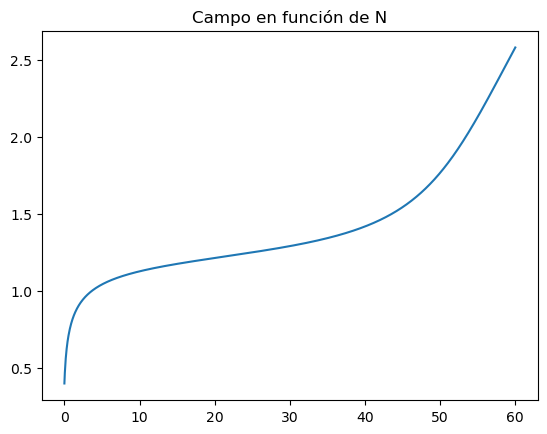

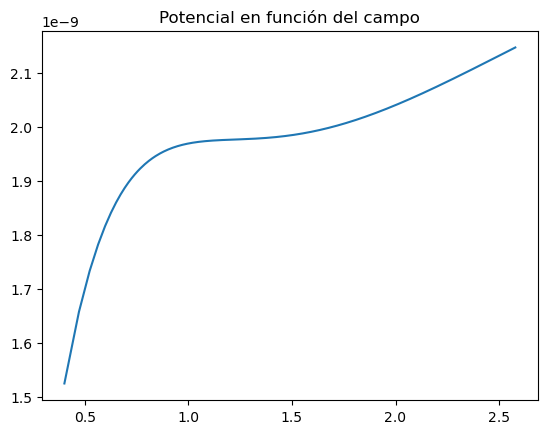

Phi_0:  0.4018668744194884 , Kappa:  1.02 , xi:  12.080325705193443
Lambda_0:  1.459373361786959e-06 , b/16/kappa:  1.409313725490196e-06


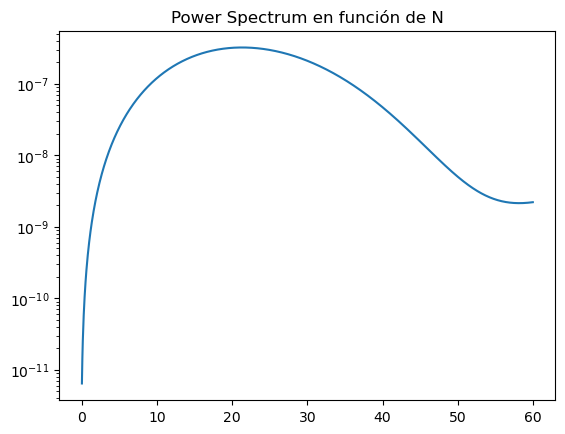

In [8]:
kappa=1.02
lambda_0_0=b/16/0.985
# x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]
x_0=[10,lambda_0_0]

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

xi=solutions.x[0]
lambda_0=solutions.x[1]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
Pot_plot_1=plot_pot(phi_0,kappa,xi,lambda_0)
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_4_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

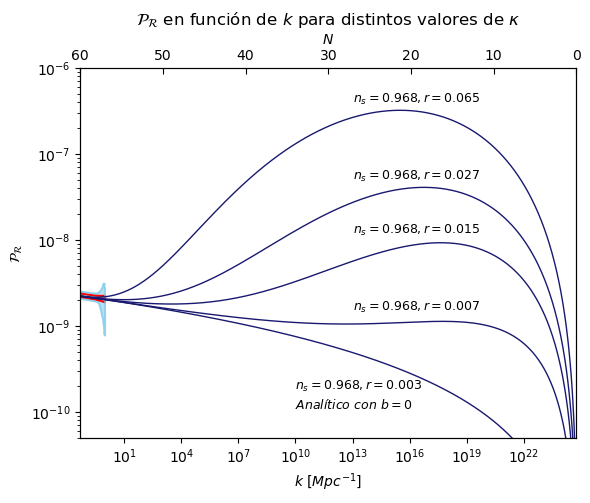

In [9]:
KCOBE = 0.05
NCOBE = 60

def k_from_n(n):
  return KCOBE * np.exp(NCOBE - n)

N=np.linspace(60,0,1000)
N_ref=np.linspace(0,60,1000)

k_plot=k_from_n(N)

bicep21s_x_new = [coord[0] for coord in PLANCK_FIG26_1SIG]
bicep21s_y_new = [coord[1] for coord in PLANCK_FIG26_1SIG]
bicep21s_y_new = 1e-10*np.exp(bicep21s_y_new)

bicep22s_x_new = [coord[0] for coord in PLANCK_FIG26_2SIG]
bicep22s_y_new = [coord[1] for coord in PLANCK_FIG26_2SIG]
bicep22s_y_new = 1e-10*np.exp(bicep22s_y_new)


plt.plot(bicep21s_x_new,bicep21s_y_new, color="red", alpha=1)
plt.fill_between( bicep21s_x_new, bicep21s_y_new, color="skyblue", alpha=1)
plt.plot(bicep22s_x_new,bicep22s_y_new, color="skyblue", alpha=0.7)
plt.fill_between( bicep22s_x_new, bicep22s_y_new, color="skyblue", alpha=0.6)

plt.plot(k_from_n(N),P_r_4_60,label="$\kappa$=1.02, $r$=0.065",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_3_60,label="$\kappa$=1.05, $r$=0.027",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_2_60,label="$\kappa$=1.07, $r$=0.015",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_1_60,label="$\kappa$=1.1, $r$=0.007",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N_ref),P_r_ref,label="b=0, $r$=0.003 (analítico)",color="midnightblue",linewidth=1.0)
# plt.legend()
plt.yscale("log")
plt.xscale('log')
plt.title("$\mathcal{P}_\mathcal{R}$ en función de $k$ para distintos valores de $\kappa$")
plt.ylim(5*10**-11,10**-6)
plt.xlabel('$k \ [Mpc^{-1}]$')
plt.ylabel('$\mathcal{P}_\mathcal{R}$')
plt.xlim(k_from_n(60),k_from_n(0))
plt.text(1e10, 1.8e-10, '$n_s=0.968, r=0.003$', fontsize = 9)
plt.text(1e10, 1.1e-10, '$Analítico\ con\ b=0$', fontsize = 9)
plt.text(1e13, 1.5e-9, '$n_s=0.968, r=0.007$', fontsize = 9)
plt.text(1e13, 1.2e-8, '$n_s=0.968, r=0.015$', fontsize = 9)
plt.text(1e13, 5e-8, '$n_s=0.968, r=0.027$', fontsize = 9)
plt.text(1e13, 4e-7, '$n_s=0.968, r=0.065$', fontsize = 9)
top_axis = plt.twiny()
top_axis.set_xlim(60, 0) 
top_axis.set_xlabel('$N$')  
plt.tick_params(axis='y', which='both', direction='in', length=2)
plt.tick_params(axis='both', direction='in', length=4)
# plt.tick_params(bottom=True,top=True)
plt.savefig('with.pdf', bbox_inches='tight')
plt.show()

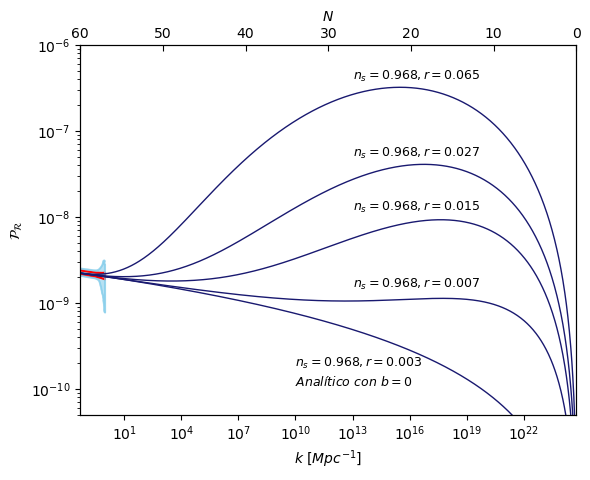

In [10]:
plt.plot(bicep21s_x_new,bicep21s_y_new, color="red", alpha=1)
plt.fill_between( bicep21s_x_new, bicep21s_y_new, color="skyblue", alpha=1)
plt.plot(bicep22s_x_new,bicep22s_y_new, color="skyblue", alpha=0.7)
plt.fill_between( bicep22s_x_new, bicep22s_y_new, color="skyblue", alpha=0.6)

plt.plot(k_from_n(N),P_r_4_60,label="$\kappa$=1.02, $r$=0.065",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_3_60,label="$\kappa$=1.05, $r$=0.027",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_2_60,label="$\kappa$=1.07, $r$=0.015",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N),P_r_1_60,label="$\kappa$=1.1, $r$=0.007",color="midnightblue",linewidth=1.0)
plt.plot(k_from_n(N_ref),P_r_ref,label="b=0, $r$=0.003 (analítico)",color="midnightblue",linewidth=1.0)
# plt.legend()
plt.yscale("log")
plt.xscale('log')
# plt.title("$\mathcal{P}_\mathcal{R}$ en función de $k$ para distintos valores de $\kappa$")
plt.ylim(5*10**-11,10**-6)
plt.xlabel('$k \ [Mpc^{-1}]$')
plt.ylabel('$\mathcal{P}_\mathcal{R}$')
plt.xlim(k_from_n(60),k_from_n(0))
plt.text(1e10, 1.8e-10, '$n_s=0.968, r=0.003$', fontsize = 9)
plt.text(1e10, 1.1e-10, '$Analítico\ con\ b=0$', fontsize = 9)
plt.text(1e13, 1.5e-9, '$n_s=0.968, r=0.007$', fontsize = 9)
plt.text(1e13, 1.2e-8, '$n_s=0.968, r=0.015$', fontsize = 9)
plt.text(1e13, 5e-8, '$n_s=0.968, r=0.027$', fontsize = 9)
plt.text(1e13, 4e-7, '$n_s=0.968, r=0.065$', fontsize = 9)
top_axis = plt.twiny()
top_axis.set_xlim(60, 0) 
top_axis.set_xlabel('$N$')  
plt.tick_params(axis='y', which='both', direction='in', length=2)
plt.tick_params(axis='both', direction='in', length=4)
# plt.tick_params(bottom=True,top=True)
plt.savefig('without.pdf', bbox_inches='tight')
plt.show()